In [1]:
import numpy as np

In [2]:
# Load cyst phantom scatterer data

import scipy.io as spio

file = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\pht_data.mat'
mat = spio.loadmat (file)

pos, amp = mat['phantom_positions'], mat['phantom_amplitudes']
scatterers = np.concatenate ([e.astype ('float32') for e in [pos, amp]], axis=-1)

print (scatterers.shape, scatterers.dtype)
print (scatterers)

(100000, 4) float32
[[ 1.5736185e-02 -2.2260530e-03  5.9821997e-02  1.6769148e+00]
 [ 2.0289596e-02  1.2283906e-03  5.5603687e-02  1.4254422e+00]
 [-1.8650658e-02 -4.6350682e-04  4.3967690e-02  7.9462148e-02]
 ...
 [-1.5000000e-02  0.0000000e+00  7.0000000e-02  2.0000000e+01]
 [-1.5000000e-02  0.0000000e+00  7.9999998e-02  2.0000000e+01]
 [-1.5000000e-02  0.0000000e+00  9.0000004e-02  2.0000000e+01]]


In [3]:
# Generate the transducer apertures for send and receive

f0 = 3.5e6                 #  Transducer center frequency [Hz]
fs = 100e6                 #  Sampling frequency [Hz]
c = 1540                   #  Speed of sound [m/s]
lambd = c / f0             #  Wavelength [m]
width = lambd              #  Width of element
height = 5 / 1000          #  Height of element [m]
kerf = 0.05 / 1000         #  Kerf (gap between elements) [m]
pitch = kerf + width       #  Pitch (center-to-center distance between elements) [m]
N_elements = 192           #  Number of physical elements
no_sub_x = 5               #  Number of sub-divisions in x-direction of elements
no_sub_y = 5              #  Number of sub-divisions in y-direction of elements

In [4]:
# Create and configure GPU simulator

from pyrfsim import RfSimulator

sim = RfSimulator ('gpu')
sim.set_print_debug (True)

sim.set_parameter ('sound_speed', str (c))
sim.set_parameter ('radial_decimation', '1') # depth-direction downsampling factor
sim.set_parameter ('phase_delay', 'on') # improves subsample accuracy
sim.set_parameter ('use_elev_hack', 'off')

In [5]:
def subdivide (length, num):
    delta = length * 1/num
    divisions = np.arange ((-num//2 + 1) * delta, (num//2 + 1) * delta, delta)
    
    return divisions

# Arguments very similar to xdc_linear_array in Field II
def linear_transducer (N_elements, width, height, kerf, no_sub_x=1, no_sub_y=1, as_array=False):
    '''Calculates the origin positions of the (sub-)elements in a linear array transducer.'''
    
    elem_x = subdivide (width, no_sub_x)
    elem_y = subdivide (height, no_sub_y)
    
    template_x = np.tile (elem_x, [1, N_elements])
    template_x = template_x.repeat (no_sub_y, axis=0)
    template_y = np.tile (elem_y.reshape(-1, 1), [1, N_elements])
    template_y = template_y.repeat (no_sub_x, axis=1)
    
    pitch = width + kerf # element center-to-center distance
    origins_x = np.arange (
        (-N_elements//2 + 1) * pitch,
        (N_elements//2 + 1) * pitch,
        pitch
    ).reshape (1, -1)
    origins_x = origins_x.repeat (no_sub_x, axis=1)
    origins_x = origins_x.repeat (no_sub_y, axis=0)
    
    transducer_x = template_x + origins_x
    transducer_y = template_y
    transducer_z = np.zeros (transducer_x.shape)
    
    if as_array:
        return np.stack ([transducer_x, transducer_y, transducer_z], axis=2)
    else:
        return {'x': transducer_x, 'y': transducer_y, 'z': transducer_z}

In [6]:
# Define a scan sequence

receive_aperture = linear_transducer (
  N_elements,
  width,
  height,
  kerf,
  no_sub_x,
  no_sub_y,
  as_array=True
)

origins = receive_aperture.reshape (-1, 3).astype ('float32')
N_subelements = origins.shape[0]
directions = np.tile (np.array ([0, 0, 1], dtype='float32'), [N_subelements, 1])
lateral_dirs = np.tile (np.array ([1, 0, 0], dtype='float32'), [N_subelements, 1])
timestamps = np.zeros (N_subelements, dtype='float32')
line_length = .09

sim.set_scan_sequence (origins, directions, line_length, lateral_dirs, timestamps)

In [7]:
# Plot transducer origins

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure (figsize=(12,8))
ax = fig.gca (projection='3d')
ax.scatter (
  origins[:,0],
  origins[:,1],
  origins[:,2],
  c=np.arange (origins.shape[0]),
  s=5,
  cmap='plasma'
)

ax.text (*origins[0], 'o Start', fontsize=14, weight='bold')
stride = N_elements * no_sub_x // 6
for i in range (stride, origins.shape[0], stride):
    ax.text (*origins[i], 'o {}'.format (i), fontsize=12, weight='ultralight')
ax.text (*origins[-1], 'o Stop', fontsize=14, weight='bold')

ax.set_xlabel ('x', color='red', fontsize=16, labelpad=10)
ax.set_ylabel ('y', color='red', fontsize=16, labelpad=10)
ax.set_zlabel ('z', color='red', fontsize=16, labelpad=10)
ax.set_title ('Transducer Origins', color='red', fontsize=22, pad=50)
ax.set_facecolor ('white')
ax.view_init (elev=45, azim=225)

plt.show()

<Figure size 1200x800 with 1 Axes>

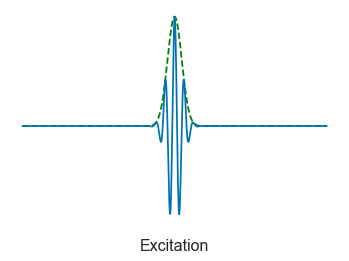

In [8]:
# Define excitation signal

from scipy.signal import gausspulse
import matplotlib.pyplot as plt

t = np.arange (-16/f0, 16/f0, 1/fs)
excitation, envelope  = gausspulse(t, fc=f0, bw=.5, retenv=True)
excitation = excitation.astype ('float32')
center_index = len (t) // 2

plt.plot(t, envelope, 'g--', t, excitation)
plt.title ('Excitation', fontsize=16, y=-.15)
plt.gca ().set_facecolor ('white')
plt.xticks ([])
plt.yticks ([])
plt.show ()

sim.set_excitation (excitation, center_index, fs, f0)

In [9]:
x_range = scatterers[:,0].min (), scatterers[:,0].max ()
y_range = scatterers[:,1].min (), scatterers[:,1].max ()
z_range = scatterers[:,2].min (), scatterers[:,2].max ()
a_range = scatterers[:,3].min (), scatterers[:,3].max ()
print ('x:', x_range)
print ('y:', y_range)
print ('z:', z_range)
print ('a:', a_range)

x: (-0.024999449, 0.024998812)
y: (-0.0049998914, 0.004999947)
z: (0.030000374, 0.09)
a: (-38.72031, 32.00978)


In [10]:
# Set scatterers

sim.clear_fixed_scatterers () # Make this cell idempotent

# transmit_aperture = linear_transducer (N_elements, width, height, kerf, no_sub_x, no_sub_y, as_array=True)
data = scatterers

sim.add_fixed_scatterers (data)

In [11]:
# Set the beam profile

sigma_lateral = 1e-3
sigma_elevational = 1e-3
sim.set_analytical_beam_profile (sigma_lateral, sigma_elevational)

In [12]:
# Simulate all scanlines

decimation = 2
sim.set_parameter ('radial_decimation', str (decimation))
sim.set_parameter ('use_elev_hack', 'off')
iq_lines = sim.simulate_lines ()
print (iq_lines.shape)

(7964, 4800)


In [13]:
# Reshaping madness.
# Key to tip: The last axis gets read the fastest, the first axis the fastest.
shape = no_sub_y, N_elements, no_sub_x, -1
reshaped = iq_lines.T.reshape (shape)
data = reshaped.sum (axis=(0,2)).T / (no_sub_y*no_sub_x)
print (reshaped.shape, data.shape)

(5, 192, 5, 7964) (7964, 192)


In [14]:
# Crop data

ROI = [z_range, x_range]
ROI = [[z*2/c*fs/decimation for z in z_range], [x/pitch for x in x_range]]

ROI[0] = [ROI[0][0], ROI[0][1]]
ROI[1] = [x+data.shape[1]/2 for x in ROI[1]]
ROI = [[int (e) for e in lims] for lims in ROI]
cropped = data[slice (*ROI[0]), slice (*ROI[1])]
print (cropped.shape, ROI[0])

(3896, 103) [1948, 5844]


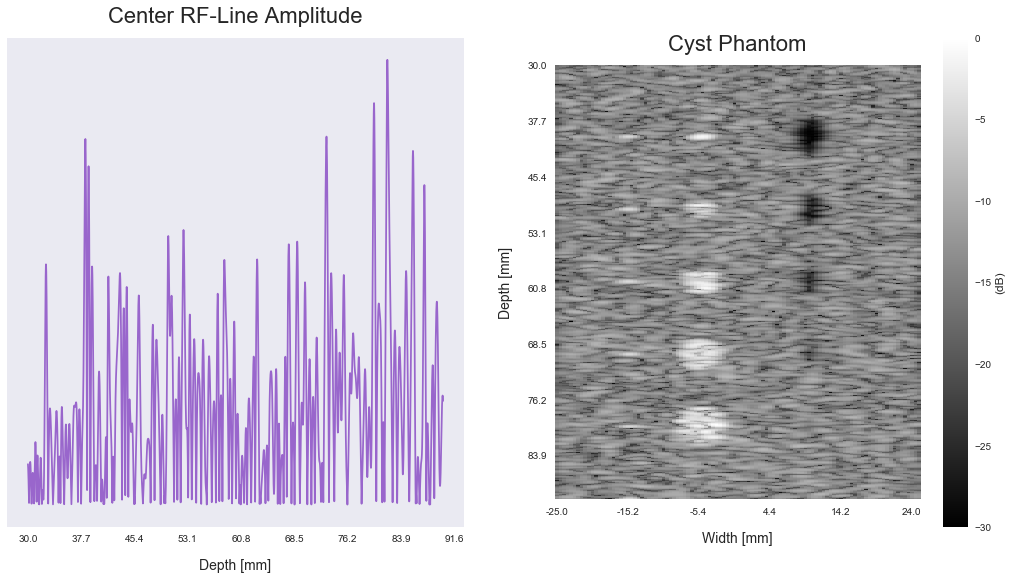

In [94]:
# Plot results

import importlib
import visualize
importlib.reload (visualize)

title = 'Cyst Phantom'

# Aspect ratio is height/width.
# The factor of 1/2 is the ratio to convert from units of time to
# depth because travel time is double the distance in the measured
# echo roundtrip.
# ratio = (c/fs/2) / (pitch/no_sub_x)
ratio = (c/fs/2) / (pitch)

# Scale back for decimation
ratio *= decimation
fig, axes = visualize.visualize (cropped, title, figsize=(18, 9), min_dB=-30, aspect_ratio=ratio, show=False)

# Set tick marks with real distances
ticks, _ = plt.xticks ()
ticks = [x for x in ticks[:-1] if x >= 0]
labels = [x*pitch+x_range[0] for x in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.xticks (ticks, labels)
plt.xlabel ('Width [mm]', fontsize=14, labelpad=15)

ticks, _ = plt.yticks ()
ticks = [t for t in ticks[:-1] if t >= 0]
labels = [decimation*t/(2*fs)*c+z_range[0] for t in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.yticks (ticks, labels)
plt.ylabel ('Depth [mm]', fontsize=14, labelpad=15)

plt.sca (axes[0])
ticks, _ = plt.xticks ()
ticks = [t for t in ticks[:-1] if t >= 0]
labels = [decimation*t/(2*fs)*c+z_range[0] for t in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.xticks (ticks, labels)
plt.xlabel ('Depth [mm]', fontsize=14, labelpad=15)

plt.show ()

In [146]:
# Load Field II rf_data to compare
# (Takes roughly 22 seconds)

# Try re-exporting the data from MATLAB. Seems to be some disagreement somewhere...
from scipy.signal import hilbert
import os
import time

tic = time.time ()
directory = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\rf_data'

field2_lines = []
for file in os.listdir (directory):
    mat = spio.loadmat (os.path.join (directory, file))
    tstart = mat['tstart'].item ()
    padding = round (tstart * fs)
    data = mat['rf_data'].reshape (-1)
    data = np.pad (data, (padding, 0), mode='constant')
    field2_lines.append (data)

max_length = max (len (line) for line in field2_lines)
field2_lines = [np.pad (line, (0, max_length - line.size), mode='constant') for line in field2_lines]
field2_lines = np.stack (field2_lines, axis=0)

# Envelope detection
field2_lines = abs (hilbert (field2_lines))
print ('{:.1f} seconds'.format (time.time () - tic))

19.0 seconds


In [126]:
# Load Field II rf_data.csv to compare
# This data was scaled by 1e22 before exporting for better precision.

'''tic = time.time ()
file = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\rf_data_export\rf_data.csv'
field2_lines_precise = []
with open (file, 'rt') as f:
    for line in f:
        line = np.r_[[float(x.strip ()) for x in line.split (',')]]
        field2_lines_precise.append (line)

field2_lines_precise = np.stack (field2_lines, axis=0)
# (Already envelop detected before export.)

print ('{:.1f} seconds'.format (time.time () - tic))
print (field2_lines_precise.shape)'''

# Conclusion: No difference.

0.4 seconds
(50, 14087)


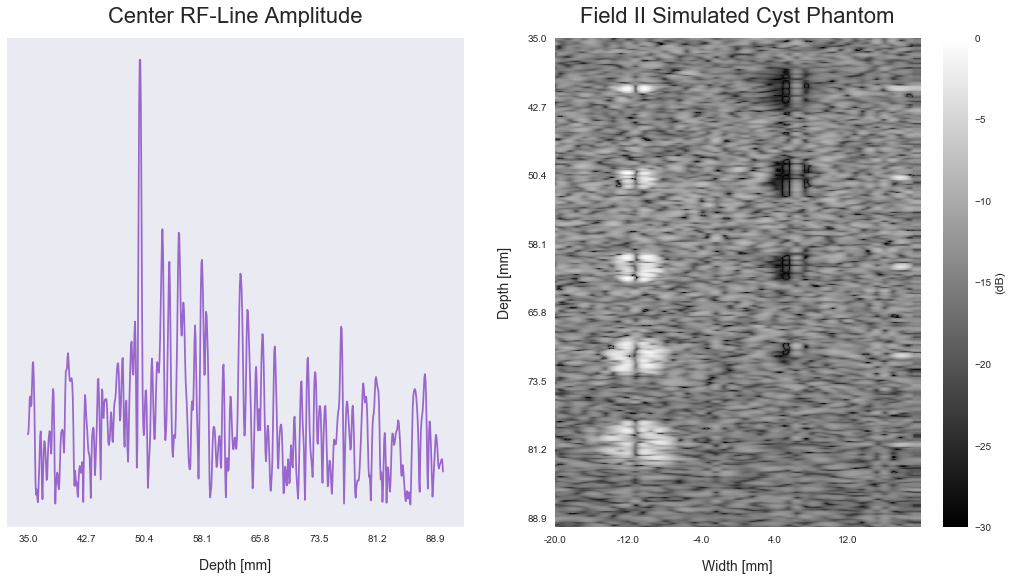

In [150]:
# Image processing... (see make_image.m in the Field II example code)

# Interpolate laterally
from scipy.interpolate import RectBivariateSpline

z_samples, x_samples = field2_lines.T.shape
interpolater = RectBivariateSpline (np.arange (z_samples), np.arange (0, 20 * x_samples, 20), field2_lines.T)
z, x = np.r_[:z_samples:10], np.r_[:20*x_samples]
interpolated = interpolater (z, x)

# Crop
crop_z = (int (e) for e in (.035/(c/2/fs)/10, .09/(c/2/fs)/10))
field2_cropped = interpolated[slice (*crop_z), :]

fig, axes = visualize.visualize (field2_cropped, 'Field II Simulated Cyst Phantom', figsize=(18, 9), min_dB=-30, show=False)

# Set tick marks with real distances
ticks, _ = plt.xticks ()
ticks = [x for x in ticks[:-1] if x >= 0]
labels = [x*.040/50/20 + -.020 for x in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.xticks (ticks, labels)
plt.xlabel ('Width [mm]', fontsize=14, labelpad=15)

ticks, _ = plt.yticks ()
ticks = [t for t in ticks[:-1] if t >= 0]
labels = [t/(2*fs)*c*10 + .035 for t in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.yticks (ticks, labels)
plt.ylabel ('Depth [mm]', fontsize=14, labelpad=15)

plt.sca (axes[0])
ticks, _ = plt.xticks ()
ticks = [t for t in ticks[:-1] if t >= 0]
labels = [t/(2*fs)*c*10 + .035 for t in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.xticks (ticks, labels)
plt.xlabel ('Depth [mm]', fontsize=14, labelpad=15)

plt.savefig ('../figures/cyst_phantom_using_field_ii_rf_data.png')
plt.show ()

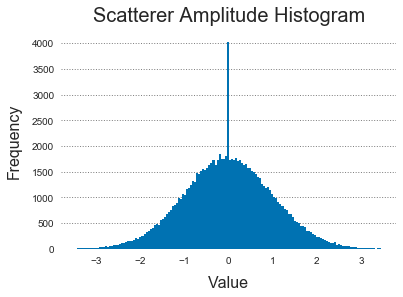

In [91]:
# Check scatterer amplitude histogram

def is_outlier(points, thresh=3.5):
    # https://stackoverflow.com/a/11886564/3624264
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff + diff.max () * 1e-6)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

amplitudes = scatterers[:, 3]
not_outlier = amplitudes[~is_outlier (amplitudes)]
plt.hist (not_outlier, bins=150)
plt.gca ().set_facecolor ('white')
plt.grid (axis='y', color='gray', linestyle=':')
plt.grid (axis='x')
plt.ylabel ('Frequency', fontsize=16, labelpad=10)
plt.xlabel ('Value', fontsize=16, labelpad=10)
plt.title ('Scatterer Amplitude Histogram', fontsize=20, pad=10)
plt.show ()

In [138]:
# Make image of true scatterer positions
# (Takes roughly 26 seconds)

import time

delta = c/fs, pitch/10
grid_size = (z_range[1] - z_range[0]) / delta[0], (x_range[1] - x_range[0]) / delta[1]
grid_size = [int (e) for e in grid_size]
image = np.zeros (grid_size)

tic = time.time ()

def gaussian_kernel (samples_wide=21, sigmas=3):
    """Returns a 2D Gaussian kernel array."""
    # https://stackoverflow.com/a/29731818/3624264
    import numpy as np
    import scipy.stats as st

    if hasattr (samples_wide, '__len__'):
        width_z, width_x = samples_wide
    else:
        width_z, width_x = samples_wide, samples_wide
    
    interval = (2*sigmas + 1) / (width_z)
    z = np.linspace (-sigmas - interval / 2., sigmas + interval / 2., width_z + 1)
    kernel_z = np.diff (st.norm.cdf (z))
    
    interval = (2*sigmas + 1) / (width_x)
    x = np.linspace (-sigmas - interval / 2., sigmas + interval / 2., width_x + 1)
    kernel_x = np.diff (st.norm.cdf (x))
    
    kernel = np.sqrt (np.outer (kernel_z, kernel_x))
    kernel /= kernel.sum ()
    
    return kernel

def apply_kernel (image, center, kernel, amplitude=1):
    half = [s//2 for s in kernel.shape]
    start = [max (e - h, 0) for e,h in zip (center, half)]
    stop = [min (e + h, dim) for e,h,dim in zip (center, half, image.shape)]
    try:
        if any (e < 0 for e in start) or any (e < 0 for e in stop):
            raise ValueError
        i,j = center
        z_slice = slice (half[0] + start[0] - i, half[0] + stop[0] - i)
        x_slice = slice (half[1] + start[1] - j, half[1] + stop[1] - j)
        image[start[0]:stop[0], start[1]:stop[1]] += amplitude * kernel[z_slice, x_slice]
    except ValueError as e:
        print (i,j)
        print (image.shape)
        print (z_slice)
        print (x_slice)
        raise e

for num,(x,z,amp) in enumerate (zip (scatterers[:,0], scatterers[:,2], scatterers[:,3])):
    x,z = (e.item () for e in (x,z))
    i,j = round ((z - z_range[0]) / delta[0]), round ((x - x_range[0]) / delta[1])
    i,j = (int (e) for e in (i,j))

    sigma = 1e-4 * abs (amp)
    samples_wide = [int (3*sigma/d) for d in delta]
    samples_wide = [max (min (e, 200), 1) for e in samples_wide] # Super important line!
    # Otherwise can crash computer from unbounded memory consumption.
    kernel = gaussian_kernel (samples_wide)
    if abs (amp) >= 1:
        apply_kernel (image, (i,j), kernel, np.sign (amp) * 10 * amp**2)
    else:
        apply_kernel (image, (i,j), kernel, amp)
    
print ('{:.1f} seconds'.format (time.time () - tic))

29.6 seconds


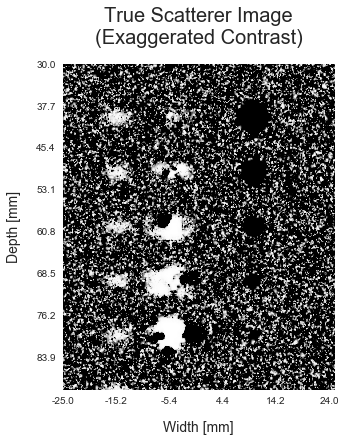

In [151]:
data = image.copy ()
# Full scale contrast stretch
# low, high = data.min (), data.max ()
# data = (data - low) / (high - low)
# Log compression
# min_dB = -30
# data = 10 * np.log10(data + 10**(min_dB/10))
# Histogram equalization
hist, bins = np.histogram (abs (data), bins=256)
cdf = np.cumsum (hist)
cdf = cdf/cdf[-1]
data = np.interp (data, bins[:-1], cdf)

plt.figure (figsize=(6,6))
plt.imshow (data, cmap='gray')
plt.gca ().set_aspect (delta[0]/delta[1])
plt.grid ()
plt.title ('True Scatterer Image\n(Exaggerated Contrast)', fontsize=20, pad=20)

# Set tick marks with real distances
ticks, _ = plt.xticks ()
ticks = [x for x in ticks[:-1] if x >= 0]
labels = [x*delta[1] + x_range[0] for x in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.xticks (ticks, labels)
plt.xlabel ('Width [mm]', fontsize=14, labelpad=15)

ticks, _ = plt.yticks ()
ticks = [t for t in ticks[:-1] if t >= 0]
labels = [t*delta[0] + z_range[0] for t in ticks]
labels = ['{:.1f}'.format (1000*l) for l in labels]
plt.yticks (ticks, labels)
plt.ylabel ('Depth [mm]', fontsize=14, labelpad=15)

plt.savefig ('../figures/cyst_phantom_true_scatterers_exaggerated_contrast.png')
plt.show ()